## 1. Features Extraction

### import modules

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import pickle
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
%matplotlib inline

### Upload datasets from GTI and KITTI

In [2]:
### input data set 
cars = glob.glob('./vehicles/**/*.png')
notcars = glob.glob('./non-vehicles/**/*.png')
print('Cars total number:',len(cars), '\nNotcars total number:',len(notcars))

Cars total number: 8792 
Notcars total number: 8968


Random number: 6124  Image shape: (64, 64, 3)
done!


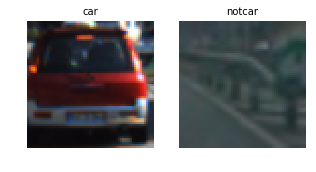

In [134]:
#visualize simple images
n = np.random.randint(0,len(cars))
plt.subplots(figsize=(5,5))
img = mpimg.imread(cars[n])
img1 = mpimg.imread(notcars[n])

plt.subplot(121)
plt.title('car', fontsize=10)
plt.imshow(img)
plt.axis('off')

plt.subplot(122)
plt.title('notcar',fontsize=10)
plt.imshow(img1)
plt.axis('off')

print('Random number:',n,' Image shape:',img.shape)
print('done!')

Random number: 7100


(-0.5, 105.5, 62.5, -0.5)

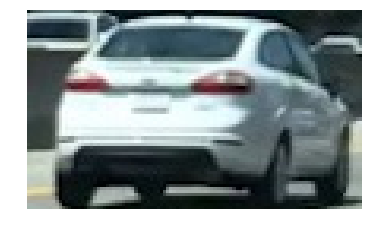

In [4]:
# Read in the image
n = np.random.randint(0,len(cars))
#image = mpimg.imread(cars[n])
image = mpimg.imread('cutout1.jpg')
# Take histograms in R, G, and B
rhist = np.histogram(image[:,:,0], bins=32, range=(0, 256))
ghist = np.histogram(image[:,:,1], bins=32, range=(0, 256))
bhist = np.histogram(image[:,:,2], bins=32, range=(0, 256))

# Generating bin centers
bin_edges = rhist[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2 #calculate the center points
print('Random number:',n)
plt.imshow(image)
plt.axis('off')

In [5]:
print(rhist)

(array([400, 441, 302, 244, 189, 283, 412, 433, 239, 177, 209, 302, 276,
       179, 129, 106, 104, 111, 106,  96, 111, 123, 139, 130, 167, 164,
       149, 156, 222, 268, 258,  53], dtype=int64), array([  0.,   8.,  16.,  24.,  32.,  40.,  48.,  56.,  64.,  72.,  80.,
        88.,  96., 104., 112., 120., 128., 136., 144., 152., 160., 168.,
       176., 184., 192., 200., 208., 216., 224., 232., 240., 248., 256.]))


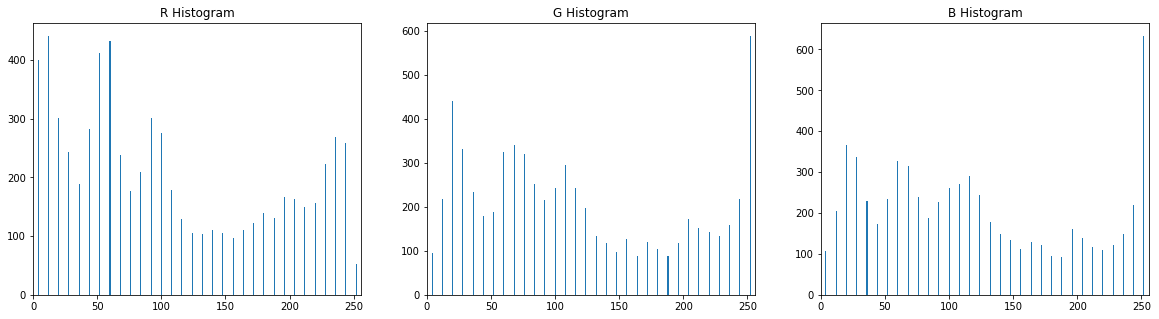

In [6]:
# Plot a figure with all three bar charts
fig = plt.figure(figsize=(20,5))
plt.subplot(131)
plt.bar(bin_centers, rhist[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(132)
plt.bar(bin_centers, ghist[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bin_centers, bhist[0])
plt.xlim(0, 256)
plt.title('B Histogram')

In [7]:
hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
print(hist_features)

[400 441 302 244 189 283 412 433 239 177 209 302 276 179 129 106 104 111
 106  96 111 123 139 130 167 164 149 156 222 268 258  53  95 219 441 331
 235 179 188 324 340 321 252 215 242 296 244 198 133 117  98 127  88 120
 104  88 117 172 152 142 133 159 219 589 106 206 367 337 230 174 235 328
 316 238 189 227 261 271 291 244 179 148 134 112 129 123  94  93 160 138
 117 110 121 148 219 633]


In [8]:
n = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[n])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
orient= 9
pix_per_cell= 8 
cell_per_block= 2
vis=True
feature_vec=False
features, hog_image = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)

(-0.5, 63.5, 63.5, -0.5)

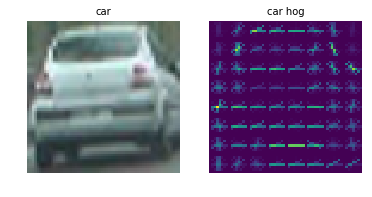

In [9]:
plt.subplot(121)
plt.imshow(image)
plt.title('car',fontsize=10)
plt.axis('off')

plt.subplot(122)
plt.imshow(hog_image)
plt.title('car hog',fontsize=10)
plt.axis('off')

### Functions: get hog features, spatial bins, color histograms, extract combined features , convert color

In [28]:
### (1) All features combined 
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
    
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

#Convert colors
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv =='RGB2HLS':
        return cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
print('done!')

done!


### Extract features for car and notcar data set

In [31]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print('done!')

done!


## 2. Classifier Training

###  Data preparation including random Shuffling of the data, splitting the data into a training and testing set, normalization of features

In [32]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('done!')

done!


### Train a classifier  

In [33]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
53.94 Seconds to train SVC...
Test Accuracy of SVC =  0.9873


### Save training data points  for lately using repeatly

In [34]:
a_dict = {'svc': svc, 'orient':orient,'pix_per_cell':pix_per_cell,'scaler':X_scaler, 
         'cell_per_block':cell_per_block,'spatial_size':spatial_size,'hist_bins':hist_bins,
         'hog_channel':hog_channel}

# pickle a variable to a file
file = open('svc_pickle.p', 'wb')
pickle.dump(a_dict, file)

print('done!')

done!


In [35]:
# load a pe-trained svc model from a serialized (pickle) file
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )

# get attributes of our svc object
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
hog_channel = dist_pickle["hog_channel"]

## 3. Search cars by Sliding Window based on features extraction and pretrained classifier

### Functions: slide window operation, draw boxes

In [36]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
print('done!')

done!


###  Find cars in images

In [37]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,hog_channel,
             show_all_rectangles=False):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ### convert to corresponding color :RGB2YUV   RGB2YCrCb
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
  
    ###scale 
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
   ###hog_channel 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]   
    
        
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    #hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1
            

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            
            if test_prediction == 1 or show_all_rectangles==True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    #return draw_img, box
    return box
print('done!')

done!


### Test `find_cars` on an image 

In [49]:
### test find_cars singlely.

test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5

box= find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
               hist_bins,hog_channel,show_all_rectangles=False)

9 boxes


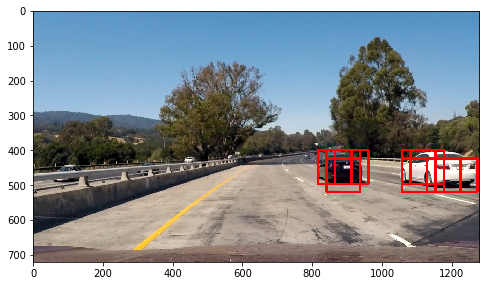

In [50]:
print(len(box), 'boxes')
out_img = draw_boxes(test_img, box)
plt.figure(figsize=(8,5))
plt.imshow(out_img)

308 boxes


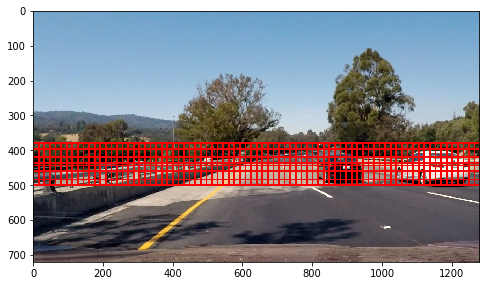

In [53]:
#combined  No.1
test_img = mpimg.imread('./test_images/test4.jpg')

#out_images=[]
box_list=[]
#No.1 furthest
ystart = 380
ystop = 470
scale = 1.0

box= find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                                 hist_bins,hog_channel,show_all_rectangles=True)
box_list.append(box)

ystart = 420
ystop = 510
scale = 1.0
box= find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                             hist_bins,hog_channel,show_all_rectangles=True)
box_list.append(box)

rect = [item for sublist in box_list for item in sublist] 
out_img = draw_boxes(test_img, rect,thick=4)

plt.figure(figsize=(8,5))
plt.imshow(out_img)
print(len(rect),'boxes')

100 boxes


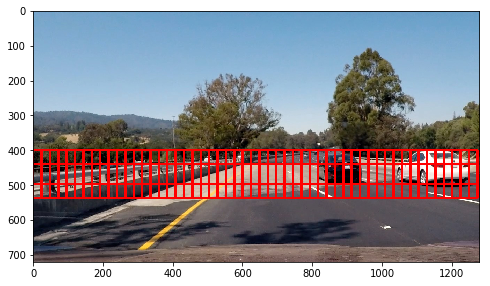

In [41]:
#combined No.2
test_img = mpimg.imread('./test_images/test4.jpg')

#out_images=[]
box_list=[]
#No.2 
ystart = 400
ystop = 500
scale = 1.5

box= find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                                 hist_bins,hog_channel,show_all_rectangles=True)
box_list.append(box)

ystart = 440
ystop = 540
scale = 1.5
box= find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                             hist_bins,hog_channel,show_all_rectangles=True)
box_list.append(box)

rect = [item for sublist in box_list for item in sublist] 
out_img = draw_boxes(test_img, rect)

plt.figure(figsize=(8,5))
plt.imshow(out_img)
print(len(rect),'boxes')

222 boxes


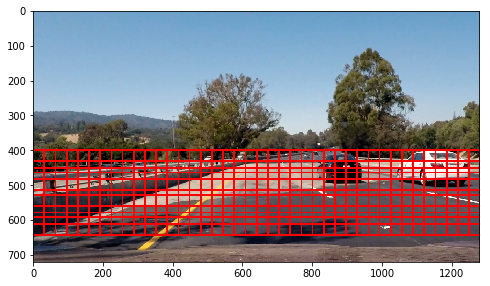

In [52]:
#combined No.3
test_img = mpimg.imread('./test_images/test4.jpg')

#out_images=[]
box_list=[]

# 
ystart = 380
ystop = 600
scale = 2.0

box= find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                                 hist_bins,hog_channel,show_all_rectangles=True)
box_list.append(box)

ystart = 430
ystop = 650
scale = 2.0
box= find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                             hist_bins,hog_channel,show_all_rectangles=True)
box_list.append(box)

rect = [item for sublist in box_list for item in sublist] 
out_img = draw_boxes(test_img, rect,thick=4)

plt.figure(figsize=(8,5))
plt.imshow(out_img)
print(len(rect),'boxes')

### heat-maps process and draw  labeled boxes

In [43]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img
print('done!')

done!


### Combine three kinds of  scaled windows

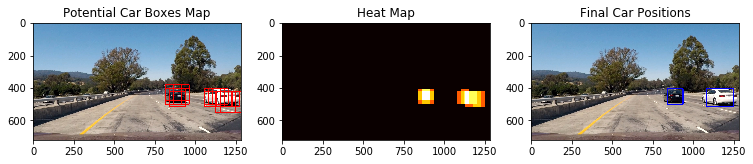

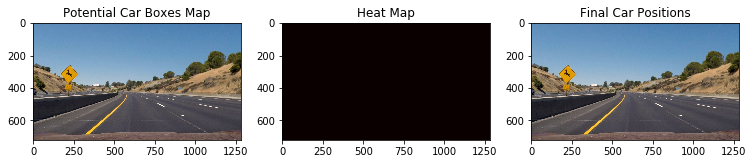

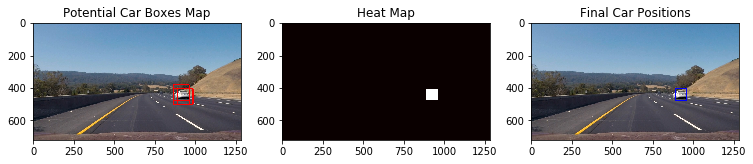

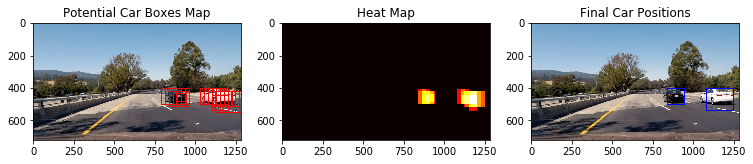

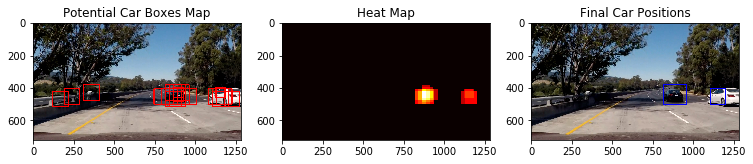

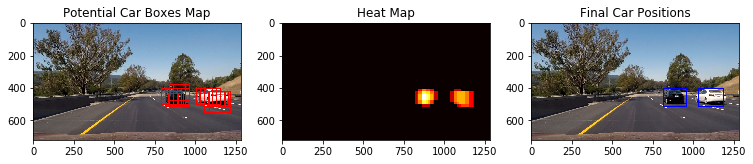

In [103]:
from scipy.ndimage.measurements import label

images = glob.glob('./test_images/*.jpg')
lens = 6
for image,n in zip(images,range(lens)):
    img = mpimg.imread(image)
    #out_images=[]
    box_list=[]
    #No.1 furthest
    ystart = 380
    ystop = 470
    scale = 1.0
    box= find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                                     hist_bins,hog_channel,show_all_rectangles=False)
    box_list.append(box)
    
    ystart = 420
    ystop = 510
    scale = 1.0
    box= find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                                     hist_bins,hog_channel,show_all_rectangles=False)
    box_list.append(box)

    # No.2 middle furthest
    #380,500,
    ystart = 380
    ystop = 500
    scale = 1.5

    box= find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                                    hist_bins,hog_channel,show_all_rectangles=False)
    box_list.append(box)
    
    ystart = 420
    ystop = 540
    scale = 1.5
    box= find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                                    hist_bins,hog_channel,show_all_rectangles=False)
    box_list.append(box)
   
   
    #No.3
    ystart = 420
    ystop = 620
    scale = 2.0
    box= find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                                     hist_bins,hog_channel,show_all_rectangles=False)
    box_list.append(box)

    ystart = 450
    ystop = 650
    scale = 2.0
    box= find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                                 hist_bins,hog_channel,show_all_rectangles=False)
    box_list.append(box)
      
    # No.4 closest,biggest
    ystart = 450
    ystop = 650
    scale = 2.5
    box= find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                                 hist_bins,hog_channel,show_all_rectangles=False)
    box_list.append(box)
    
    #draw boxes
    rect = [item for sublist in box_list for item in sublist] 
    out_img = draw_boxes(img, rect)
    
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,rect)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    
    plt.figure(figsize=(20,25))
    plt.subplots_adjust(hspace = .35, wspace=.2,left=.5, right=.99)
    plt.subplot(6,3,3*n+1)
    plt.imshow(out_img)
    plt.title('Potential Car Boxes Map')
    plt.subplot(6,3,3*n+2)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.subplot(6,3,3*n+3)
    plt.imshow(draw_img)
    plt.title('Final Car Positions')

## 4. Tracking Pipeline

In [81]:
### Tracking Pipeline
def Pipeline(img):
    #img = mpimg.imread(image)
    box_list=[]
    #No.1 furthest
    ystart = 380
    ystop = 470
    scale = 1.0
    box= find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                                     hist_bins,hog_channel,show_all_rectangles=False)
    box_list.append(box)
    
    ystart = 420
    ystop = 510
    scale = 1.0
    box= find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                                     hist_bins,hog_channel,show_all_rectangles=False)
    box_list.append(box)

    # No.2 middle furthest
    #380,500,
    ystart = 380
    ystop = 500
    scale = 1.5
    box= find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                                    hist_bins,hog_channel,show_all_rectangles=False)
    box_list.append(box)
    
    ystart = 420
    ystop = 540
    scale = 1.5
    box= find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                                    hist_bins,hog_channel,show_all_rectangles=False)
    box_list.append(box)
   
   
    #No.3
    ystart = 420
    ystop = 620
    scale = 2.0
    box= find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                                     hist_bins,hog_channel,show_all_rectangles=False)
    box_list.append(box)

    ystart = 450
    ystop = 650
    scale = 2.0
    box= find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                                 hist_bins,hog_channel,show_all_rectangles=False)
    box_list.append(box)
      
    # No.4 closest,biggest
    ystart = 450
    ystop = 650
    scale = 2.5
    box= find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                                 hist_bins,hog_channel,show_all_rectangles=False)
    box_list.append(box)
    
    #draw boxes
    rect = [item for sublist in box_list for item in sublist] 
    out_img = draw_boxes(img, rect)
    
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,rect)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

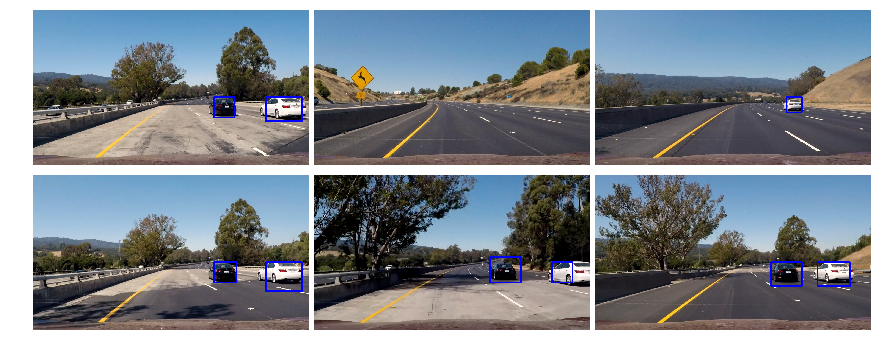

In [125]:
images = glob.glob('./test_images/test*.jpg')
 
fig, axs = plt.subplots(2, 3, figsize=(15,6))
fig.subplots_adjust(hspace =0.02, wspace=.02)
axs = axs.ravel()
for i, image in enumerate(images):
    img = mpimg.imread(image)
    final_img = Pipeline(img) 
    axs[i].imshow(final_img)
    axs[i].axis('off')

In [128]:
'''
images = glob.glob('./test_images/test*.jpg')
for i, image in enumerate(images):
    img = mpimg.imread(image)
    final_img = Pipeline(img)   
    plt.figure(figsize=(15,6))
    plt.subplots_adjust(hspace = .35, wspace=.2,left=.5, right=.99)
    plt.subplot(2,3,i+1)
    plt.imshow(final_img)  
'''

"\nimages = glob.glob('./test_images/test*.jpg')\nfor i, image in enumerate(images):\n    img = mpimg.imread(image)\n    final_img = Pipeline(img)   \n    plt.figure(figsize=(15,6))\n    plt.subplots_adjust(hspace = .35, wspace=.2,left=.5, right=.99)\n    plt.subplot(2,3,i+1)\n    plt.imshow(final_img)  \n"

## 5. Video Test

In [129]:
### test video clip
from moviepy.editor import VideoFileClip
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(Pipeline)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|██████████████████████████████████████████▊ | 38/39 [00:58<00:01,  1.55s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 59.8 s


In [130]:
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(Pipeline)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|███████████████████████████████████████▉| 1260/1261 [30:40<00:01,  1.46s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 30min 41s


In [131]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))